In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from langdetect import detect

In [ ]:
df = pd.read_csv('merged.csv' , sep='\t', encoding='utf-8', index_col=0)
df

# EDA and Data Cleaning

In [ ]:
df.info()

In [ ]:
df.nunique()

In [ ]:
df['gender'].value_counts()

We should combine these 'x number of male and y number of female' as mixed litters and remove the numbers from the others

In [ ]:
df['gender'] = df['gender'].apply(lambda x: 'Mixed' if (' male' in x and 'female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Female' if (' female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Male' if (' male' in x) else x)
df['gender'].value_counts()

This is satisfactory enough. Mare, Gelding and Stallion are horses.

In [ ]:
ax = df.gender.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [ ]:
df.nunique()

In [ ]:
df['seller_type'].value_counts()

In [ ]:
ax = df.seller_type.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [ ]:
df['seller_location'].value_counts().tail(100)

Funny to have location data in foreign language. Probably should take a look at the posting.

In [ ]:
df.loc[df['seller_location'] == 'Солфорд']

It looks fine, only location column is in foreign language. Caution have to be taken as we might have listing completely in foreign language.

In [ ]:
df['age'].value_counts().tail(20)

Some of these are very funny. probably it's the year of birth. Longer living animals tends to have their year of birth recorded as age, horses in particular

In [ ]:
df.loc[df['pet_type'] == 'horses']

298 is just right the sum of mare, gelding and stallion. We can also see that horses have their year of birth listed as their age.

In [ ]:
df['pet_type'].value_counts()

In [ ]:
df['price'].value_counts()

In [ ]:
df.sort_values(by=['price'], ascending=False).head(30)

some of the pricing makes no sense, owner probably want potential buyer to contact them. We should drop these. these outliers make price histogram unworkable. We may use boxplot to identify them.

In [ ]:
df.loc[df['price'] == 0.0]

Make sense for adoption, questionable for sale. These are either misplaced listing or placeholder price.

In [ ]:
def price_plot_hist (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xlabel(entry)
        plt.xticks(rotation=90)
        sns.distplot(x = data.loc[data[column] == entry].price)
        plt.show()

In [ ]:
price_plot_hist (df,'pet_type')

Histogram don't look good because of extreme outliers. Horses and Lifestock look rather fine.

In [ ]:
def price_plot_box (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.boxplot(x = data.loc[data[column] == entry].price).set_title(entry)
        plt.show()

In [ ]:
price_plot_box (df,'pet_type')

We could see that each pet types have their own outliers. 2000 doesn't look strange for dogs or cats but it's a sore thumb for poultry. This shows us that we should remove outliers by pet types.

In [ ]:
# plot value_counts of Series
ax = df.pet_type.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [ ]:
df['age'].str.startswith('Due').value_counts()

135 of the listing aren't born yet. Let us convert age to workable numbers, it might provide some useful insight. We can convert those that aren't due yet or just born to zero while the rest are converted to number of years.

In [ ]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [ ]:
def process_age_to_year(age):
    age = str(age)
    value = np.mean([int(s) for s in age.split() if s.isdigit()])
    if "Due" in age:
        newage = 0
    elif "Just Born" in age:
        newage = 0
    elif "month" in age: 
        newage = value/12
    elif "week" in age: 
        newage = value/52
    elif "day" in age: 
        newage = value/365
    elif "year" in age: 
        if value > 100:
            newage = 2022 - value
        else:
            newage = value
    else:
        if age == 'unknown':
            newage = np.nan
        else:
            age = int(age)
            if age > 100:
                newage = 2022 - age
            else:
                newage = age
    return newage

In [ ]:
df['year'] = df['age'].map(lambda x: process_age_to_year(x))

In [ ]:
df

It looks good.

In [ ]:
df.describe()

In [ ]:
def year_plot_box (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.boxplot(x = data.loc[data[column] == entry].year).set_title(entry)
        plt.show()

In [ ]:
year_plot_box (df,'pet_type')

There are some strange values that look rather unrealistic.

In [ ]:
ax = df.listing_type.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [ ]:
df.corr()

After looking more at the data, what I'm sure of:
- There are duplicates that scraper couldn't identify. This is likely because title and description changed during scraping.
- Some sellers put deposit as sale price, which explains why some listing looks extremely cheap
- Some cheap listing is because owner couldn't take care of the pet anymore and look for new family to take over
- Odd entries are because owner want to get in contact before deciding the sale
- Some listing are service offers which we are not interested in
- Correlation between price and age is weak

Data that we need to remove:
- Duplicates
- Those that aren't actual sale price. The hard part is identifiying them.
- Listing that are not in English. Those are likely to cause problems with NLP model.
- Those that service (microchipping, dog walking, etc)

To remove duplicates, we could ignore description and title column. The other columns are less likely to change after reposting.

Identify those listing not in english with langdetect.

### Dropping outliers for each pet type

In [ ]:
df1=df
df1.dropna(inplace=True)
df1.drop(df1[(df1['price'] > 22000)].index, inplace=True) #those above 22000 are exceedingly exhorbitant
df1.drop(df1[(df1['price'] == 12345.0)].index, inplace=True) #the number look suspicious, checking the entry proved suspicion
df1.drop(df1[(df1['price'] == 1234.0)].index, inplace=True) #same as above
df1.drop(df1[(df1['pet_type'] == 'reptiles') & (df1['price'] > 1200)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'birds') & (df1['price'] > 10000)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'fish') & (df1['price'] > 2000)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'poultry') & (df1['price'] > 1000)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'rabbits') & (df1['price'] > 1000)].index, inplace=True)
df1.drop(df1[(df1['listing_type'] == 'sale') & (df1['Title'].str.contains('service'))].index, inplace=True)
df1.drop(df1[(df1['listing_type'] == 'sale') & (df1['Title'].str.contains('Services'))].index, inplace=True)
df1.drop(df1[(df1['listing_type'] == 'sale') & (df1['price'] == 0.0)].index, inplace=True) #sale couldn't be zero
#other listings don't look unusual enough to drop
#sometimes title and description changes during scraping and we need to remove those.
df1 = df1[~df1.duplicated(subset=['price', 'species', 'age', 'gender', 'seller_name', 'seller_location','seller_type',
                                  'listing_type','pet_type'])].reset_index(drop=True)

In [ ]:
price_plot_box (df1,'pet_type')

In [ ]:
df1.sort_values(by=['price'], ascending=False).head(30)

In [ ]:
df1.describe()

### Saving the data so I don't have to rerun the code above again.

In [ ]:
df1.to_csv('cleaned_data.csv', sep='\t', encoding='utf-8')

# Building the models

### Load in the the cleaned data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df_clean = pd.read_csv('cleaned_data.csv' , sep='\t', encoding='utf-8', index_col=0)

In [2]:
df_clean

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type,year
0,unsexed green tree python + 60cm vivtek,1000.0,Python Snake,3 years,Mixed,~3years old gtp biak x sorong Typical gtp a...,Patryk M.,Aberdeen,Individual,sale,reptiles,3.000000
1,Leopard gecko (f),80.0,Gecko,1 year,Female,Selling this leopard gecko I've had the joy of...,Dana I.,Aberdeen,Individual,sale,reptiles,1.000000
2,rexy,100.0,Iguana,4 years,Male,rexy needs a new home ASP sadly I don't not ...,Gillian W.,Aberdeen,Individual,sale,reptiles,4.000000
3,Panther Chameleon and full set up,550.0,Chameleon,9 months,Male,Blue is a 6 month old Nosey Mitsio chameleon. ...,Craig H.,Aberdeen,Individual,sale,reptiles,0.750000
4,Hand reared white Indian ringnecks,300.0,Parakeets,9 weeks,Mixed,I have 2 stunning white Indian ringnecks. 1 ma...,Dave T.,Aberdeen,Individual,sale,birds,0.173077
...,...,...,...,...,...,...,...,...,...,...,...,...
41704,canarys for sale all colour plus new colours,40.0,Canaries,7 weeks,Mixed,there are all mixed cocks and hens new volour ...,Robert n.,Knottingley,Breeder,sale,birds,0.134615
41705,TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW,2150.0,Macaws,4 years,Male,Rainbow is a beautiful example of a blue and g...,The Bradford Birdman,Bradford,Licensed Breeder,sale,birds,4.000000
41706,Hand reared indian ringnecks babys,350.0,Parrots,1 year,Male,Hand reared cuddly silly tame little babys for...,Waqar A.,Bradford,Breeder,sale,birds,1.000000
41707,One yellow one orange canary.,60.0,Canaries,2 years,Mixed,I’m reluctantly listing my canaries (peach and...,Amylia R.,Barnsley,Individual,sale,birds,2.000000


## Predict if the pet is expensive or affordable

Our cleaned data has 41709 rows. Before we build a model to predict price (the actual number), let us build a model to predict a binary variable if a pet is expensive or affordable (ignoring mantenance cost). We could use the median as separator, expensive if the price is above median, affordable if below it.

In [3]:
df_clean.describe()

,price,year
count,41709.000000,41709.000000
mean,656.785922,0.946241
std,805.731562,1.722083
min,0.000000,0.000000
25%,100.000000,0.153846
50%,395.000000,0.250000
75%,1000.000000,1.000000
max,22000.000000,66.000000


In [4]:
df_clean.nunique()

Title              35401
price                378
species              436
age                   98
gender                 7
description        38842
seller_name        20384
seller_location     1081
seller_type            5
listing_type           3
pet_type              11
year                  56
dtype: int64

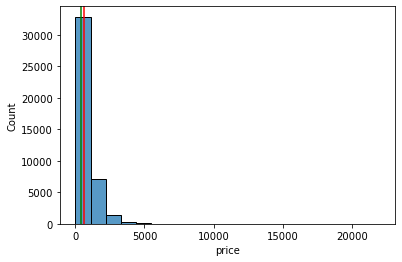

In [5]:
ax = sns.histplot(df_clean['price'], bins=20)
ax.axvline(df_clean['price'].mean(), c='r')
ax.axvline(df_clean['price'].median(), c='g')

Our data is rather skewed on one side. This is probably because there are a lot of expensive dogs. Dogs overall have higher price range.

In [6]:
median_price = np.median(df_clean.price)
median_price

395.0

In [7]:
df_clean['price_class'] = [1 if i > median_price else 0 for i in df_clean.price]

In [8]:
df_clean.price_class.value_counts()

0    20885
1    20824
Name: price_class, dtype: int64

And the baseline accuracy is

In [9]:
df_clean.price_class.value_counts(normalize=True)

0    0.500731
1    0.499269
Name: price_class, dtype: float64

### Create a classification model to predict High/Low price.

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,classification_report, roc_curve, auc, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
scaler = StandardScaler()

In [11]:
def model_fitter(model, X_train, y_train, X_test, y_test, cv=5):
    model.fit(X_train, y_train)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=cv))
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print ('the cv score is',cv_score)
    print ('the training score is',training_score)
    print ('the test score is',test_score)

In [12]:
#dummify and train test split
X = pd.get_dummies(df_clean[['pet_type']])
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = df_clean.price_class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.3, random_state=8)
model = LogisticRegression()
model_fitter(model, X_train, y_train, X_test, y_test)

the cv score is 0.7902791925808275
the training score is 0.7902794903411426
the test score is 0.7938144329896907


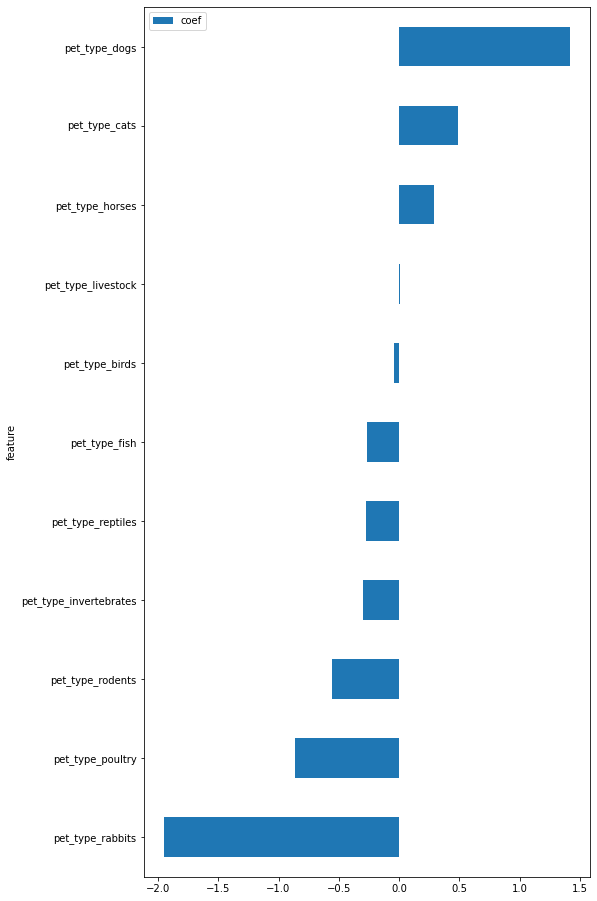

In [13]:
pd.DataFrame(list(zip(X.columns, model.coef_[0])), 
             columns=['feature', 'coef'])\
    .sort_values(by='coef') \
    .plot(kind='barh', x='feature', y='coef', figsize=(8, 16))
plt.show()

Dogs are more expensive compared with others as expected. Rather surprising that rabbits have the lowest coefficient.

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
model_fitter(knn, X_train, y_train, X_test, y_test)

the cv score is 0.7902791925808275
the training score is 0.7902794903411426
the test score is 0.7938144329896907


Let's build another model, with more variables this time.

In [15]:
#dummify and train test split
X_more = pd.get_dummies(df_clean[['pet_type','seller_type','listing_type', 'species' , 'gender']])
X_more = pd.DataFrame(scaler.fit_transform(X_more), columns=X_more.columns)
y_more = df_clean.price_class
X_more_train, X_more_test, y_more_train, y_more_test = train_test_split(X_more,
                                                    y_more, test_size=0.3, random_state=8)

In [16]:
log_more = LogisticRegression(penalty='none', max_iter=1000)
model_fitter(log_more, X_more_train, y_more_train, X_more_test, y_more_test)

the cv score is 0.8993355378454277
the training score is 0.9029661597479107
the test score is 0.8987453048829218


In [17]:
knn_more = KNeighborsClassifier(n_neighbors=5)
model_fitter(knn_more, X_more_train, y_more_train, X_more_test, y_more_test)

the cv score is 0.894300657834542
the training score is 0.9009110837100973
the test score is 0.8904339486933589


Increasing the number of variables gives overall better results. The current model is approximately 90% accurate. We can further improve it by looking at the title and description.

### NLP model to predict high or low

In [ ]:
# Create a few new variables in dataframe to represent interesting features of a listing title and description
# I'm not sure how to do it in elegant way, so I would just create a function for this.
# converts text to raw text with no punctuations or numbers.
import re
def clean_text(row):

    regex = re.compile("[^a-zA-Z']")
    row = row.lower()
    row = regex.sub(' ', row)
    row = ' '.join(row.split())
    regex = re.compile("\'")
    row = regex.sub('', row)

    return row
def standardize(row):
    """
       Standardize text variations: 'gtp' -> 'green tree python',
                                    'JR' -> 'Jack Russell',
        The list would be expanding
     """
    
    row = row.replace(r'gtp', 'green tree python')
    row = row.replace(r'JR','Jack Russell')
    row = row.replace(r'canarys','canary').replace(r'canaries','canary')
    row = row.replace(r'babys','baby').replace(r'babies','baby')
    row = row.replace(r'aailable','available')
    row = row.replace(r'asp','as soon as possible')
    return row

def combine_text(row):
    
    city = row['seller_location']
    summary = row['description']
    title = row['Title']
    text = city + ' ' + title + ' ' + summary
    
    return text

In [19]:
df_text = df_clean
df_text['text'] = df_text.apply(combine_text, axis=1)
df_text['text'] = df_text['text'].apply(clean_text)
df_text['text'] = df_text['text'].apply(standardize)
df_text

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type,year,price_class,text
0,unsexed green tree python + 60cm vivtek,1000.0,Python Snake,3 years,Mixed,~3years old gtp biak x sorong Typical gtp a...,Patryk M.,Aberdeen,Individual,sale,reptiles,3.000000,1,aberdeen unsexed green tree python cm vivtek y...
1,Leopard gecko (f),80.0,Gecko,1 year,Female,Selling this leopard gecko I've had the joy of...,Dana I.,Aberdeen,Individual,sale,reptiles,1.000000,0,aberdeen leopard gecko f selling this leopard ...
2,rexy,100.0,Iguana,4 years,Male,rexy needs a new home ASP sadly I don't not ...,Gillian W.,Aberdeen,Individual,sale,reptiles,4.000000,0,aberdeen rexy rexy needs a new home asp sadly ...
3,Panther Chameleon and full set up,550.0,Chameleon,9 months,Male,Blue is a 6 month old Nosey Mitsio chameleon. ...,Craig H.,Aberdeen,Individual,sale,reptiles,0.750000,1,aberdeen panther chameleon and full set up blu...
4,Hand reared white Indian ringnecks,300.0,Parakeets,9 weeks,Mixed,I have 2 stunning white Indian ringnecks. 1 ma...,Dave T.,Aberdeen,Individual,sale,birds,0.173077,0,aberdeen hand reared white indian ringnecks i ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41704,canarys for sale all colour plus new colours,40.0,Canaries,7 weeks,Mixed,there are all mixed cocks and hens new volour ...,Robert n.,Knottingley,Breeder,sale,birds,0.134615,0,knottingley canary for sale all colour plus ne...
41705,TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW,2150.0,Macaws,4 years,Male,Rainbow is a beautiful example of a blue and g...,The Bradford Birdman,Bradford,Licensed Breeder,sale,birds,4.000000,1,bradford tame talking harness trained blue gol...
41706,Hand reared indian ringnecks babys,350.0,Parrots,1 year,Male,Hand reared cuddly silly tame little babys for...,Waqar A.,Bradford,Breeder,sale,birds,1.000000,0,bradford hand reared indian ringnecks baby han...
41707,One yellow one orange canary.,60.0,Canaries,2 years,Mixed,I’m reluctantly listing my canaries (peach and...,Amylia R.,Barnsley,Individual,sale,birds,2.000000,0,barnsley one yellow one orange canary i m relu...


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]\\b')

In [21]:
vectorizer.fit(df_text.text)
text_vec = vectorizer.transform(df_text.text)
text_vec

<41709x26152 sparse matrix of type '<class 'numpy.float64'>'
	with 882299 stored elements in Compressed Sparse Row format>

In [22]:
# convert the text_vec to dataframe
df  = pd.DataFrame(text_vec.todense(),
                   columns = vectorizer.get_feature_names())

df.transpose().head(50).transpose()

,aa,aaa,aal,aardeens,aarden,aare,ab,aba,abacot,abandoned,...,abigail,abili,abilities,ability,abingdon,abit,abk,abkc,abl,able
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
41705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
41706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
41707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [23]:
#train test split for nlp featured models
X_nlp = df
X_nlp_train, X_nlp_test, y_nlp_train, y_nlp_test = train_test_split(X_nlp,
                                                    y, test_size=0.3, random_state=8)

These models would take a while to run, proceed with that in mind.

In [24]:
dtc = DecisionTreeClassifier(max_depth=15)
model_fitter(dtc, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

the cv score is 0.825592461647824
the training score is 0.8650842581175503
the test score is 0.8280987772716375


In [25]:
bagger_dtc = BaggingClassifier(base_estimator = dtc, max_samples=1.)
model_fitter(bagger_dtc, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

the cv score is 0.8342580358336832
the training score is 0.870769968488834
the test score is 0.8368097178933909


In [26]:
random_forest_dtc = RandomForestClassifier(max_depth=None, n_estimators=10, max_features = 300)
model_fitter(random_forest_dtc, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

the cv score is 0.8615564449720466
the training score is 0.9942115358268256
the test score is 0.8682170542635659


In [ ]:
# set up parameter for gridsearchCV
# this takes pretty long, go grab some coffee
dtc_params = {
    'max_depth':[None, 5,10,15,20],
    'max_features':[None, 50, 100, 200, 300],
    'min_samples_split':[10,15,20,25,30]
}
dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)
model_fitter(dtc_gs, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


Random forest model likely overfits.

### Model accuracy of NLP model

In [ ]:
def model_accuracy(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_pred)
    con_matrix = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred, target_names=['lower price', 'higher price'])
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_score)
    print (str(model))
    print ('accuracy score is',accuracy)
    print ('auc score is',auc_score)
    print ('-'*55, '\n')
    print ('the confusion matrix is:\n',con_matrix)
    print ('-'*55, '\n')
    print ('and the classification report:\n', class_report)
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500)
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()
    precision, recall, thresholds = precision_recall_curve(y, y_score)
    fig1 = px.area(
        x=recall, y=precision,
        title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500)
    fig1.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0)
    fig1.update_yaxes(scaleanchor="x", scaleratio=1)
    fig1.update_xaxes(constrain='domain')
    fig1.show()

In [ ]:
model_accuracy(log_more, X_more, y_more)

In [ ]:
model_accuracy(bagger_dtc, X_nlp, y)

In [ ]:
model_accuracy(random_forest_dtc, X_nlp, y)

In [ ]:
model_accuracy(dtc_gs, X_nlp, y)

## Price Prediction

We would now dive deeper into the subject and make predition of the price

In [ ]:
#dummify and train test split
X_more_price = pd.get_dummies(df_clean[['pet_type','seller_type','listing_type', 'species' , 'gender']])
X_more_price = pd.DataFrame(scaler.fit_transform(X_more_price), columns=X_more_price.columns)
y_more_price = df_clean.price
X_more_price_train, X_more_price_test, y_more_price_train, y_more_price_test = train_test_split(X_more_price,
                                                    y_more_price, test_size=0.3, random_state=8)

In [ ]:
#linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model_fitter(model, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

In [ ]:
sale = df.loc[df['listing_type'] == 'sale']

In [ ]:
sale.describe()

Let us take a look at 0.0 sale price

In [ ]:
sale.loc[sale['price'] == 0 ]

It's less than 2% of our data, how about the outliers?

In [ ]:
sale.sort_values(by=['price'], ascending=False).head(30)

In [ ]:
sale['price'].value_counts()

In [ ]:
sale.loc[sale['pet_type'] == 'dogs' ].describe()

In [ ]:
sale.loc[sale['pet_type'] == 'dogs' ].sort_values(by=['price'], ascending=True).head(30)

In [ ]:
sale.loc[(sale['pet_type'] == 'dogs') & (sale['Title'].str.contains('deposit')) ].sort_values(by=['price'], ascending=True)

In [ ]:
df = df[~df.duplicated(subset=['price', 'species', 'age', 'gender', 'seller_name', 'seller_location','seller_type',
                               'listing_type','pet_type'])].reset_index(drop=True)
df

In [ ]:
df['language'] = df['description'].apply(detect)

In [ ]:
df

In [ ]:
#dropping values
sale.drop(sale[sale['price'] > 5000].index, inplace=True)
sale.drop(sale[sale['price'] == 0.0].index, inplace=True)

In [ ]:
sale.sort_values(by=['price'], ascending=False).head(30)

In [ ]:
sale.describe()

In [ ]:
histogram (sale,'pet_type')

In [ ]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [ ]:
def process_age_to_year(age):
    age = str(age)
    value = np.mean([float(s) for s in sal.split() if s.isdecimal() or isfloat(s)])
    if "year" in sal:
        newsal = value
    elif "month" in sal: 
        newsal = value*12
    elif "week" in sal: 
        newsal = value*50
    elif "day" in sal: 
        newsal = value*200
    elif "hour" in sal: 
        newsal = value*2000
    else:
        newsal = sal
    return newsal

In [ ]:
df['year'] = df['age']
df['year'] = df['year'].apply(lambda x: 0 if ('Due' in x) else x)
df['year'] = df['year'].apply(lambda x: float(str(x).replace(' weeks',''))/52 if ('weeks' in x) else x)
df['year'] = df['year'].apply(lambda x: float(x) if (float(x)>100) else float(x))